# Analyzing the Blood Glucose Level Decrease
## Task
Physical activity such as walking has an effect on blood glucose levels: spending energy means burning
your glucose. This can be dangerous: if blood glucose decreases too much, the patient might run into a
hypoglycemic event, with potentially severe consequences. 

However, blood glucose is affected by a wide
range of other factors. A good proxy of all these factors is the time of the day, since for example meals tend
to repeat at the same time.
Through the Analysis on the Given data for a specific patient, **how likely is it that the blood glucose level will
decrease between time t and 30 minutes after t of more than 20 mg/dL**, considering as input:
*   the blood glucose levels at t and before
*   the step count at t and before
*  the time of the day of t ?

## Input Data
There are two files available:
* **blood-glucose.csv** is a CSV file with each line reporting a timestamp and a blood glucose level
(expressed in mg/dL), measured every 5 minutes. Please note that some values are missing.
* **step-count.csv** is a CSV file with each line reporting a timestamp and a number of steps walked
by the patient in the previous 5 minutes.

### Import the Required Libraries

In [0]:
from google.colab import files
import numpy as np
import pandas as pd
from datetime import date
from datetime import time
from datetime import datetime
import matplotlib.pyplot as plt

### Read the Data
First upload the required files and then Read.

In [1]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving blood-glucose.csv to blood-glucose.csv
Saving step-count.csv to step-count.csv
User uploaded file "blood-glucose.csv" with length 94960 bytes
User uploaded file "step-count.csv" with length 95910 bytes


In [0]:
bg = pd.read_csv('blood-glucose.csv',names = ["timestamp", "bglevel"])
sc = pd.read_csv('step-count.csv',names = ["timestamp", "stepcount"])

### Explore the Data

#### Sample Rows

In [12]:
bg.iloc[:5,:]

,timestamp,bglevel
0,2017-11-06 10:55:00+00:00,152.0
1,2017-11-06 11:00:00+00:00,134.0
2,2017-11-06 11:05:00+00:00,123.0
3,2017-11-06 11:10:00+00:00,119.0
4,2017-11-06 11:15:00+00:00,133.0


In [14]:
sc.iloc[:5,:]

,timestamp,stepcount
0,2017-11-06 00:00:00+00:00,0.0
1,2017-11-06 00:05:00+00:00,0.0
2,2017-11-06 00:10:00+00:00,0.0
3,2017-11-06 00:15:00+00:00,0.0
4,2017-11-06 00:20:00+00:00,0.0


#### Count of Records

In [18]:
bg.shape

(2988, 2)

In [19]:
sc.shape

(3168, 2)

#### Data Types

In [23]:
bg.dtypes

timestamp     object
bglevel      float64
dtype: object

In [24]:
sc.dtypes

timestamp     object
stepcount    float64
dtype: object

Convert timestamp column into datetime type

In [0]:
bg["timestamp"]=bg.timestamp.apply(lambda x:datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S'))
sc["timestamp"]=sc.timestamp.apply(lambda x:datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S'))

In [35]:
bg.dtypes

timestamp    datetime64[ns]
bglevel             float64
dtype: object

In [36]:
sc.dtypes

timestamp    datetime64[ns]
stepcount           float64
dtype: object

#### Summary Stats

In [37]:
bg.describe()

,bglevel
count,2893.000000
mean,204.946077
std,83.492062
min,53.000000
25%,139.000000
50%,184.000000
75%,268.000000
max,401.000000


In [38]:
sc.describe()

,stepcount
count,3168.000000
mean,25.453125
std,82.173946
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,844.000000


In [39]:
bg["timestamp"].describe()

count                    2988
unique                   2988
top       2017-11-12 00:45:00
freq                        1
first     2017-11-06 10:55:00
last      2017-11-16 19:50:00
Name: timestamp, dtype: object

In [40]:
sc["timestamp"].describe()

count                    3168
unique                   3168
top       2017-11-14 06:30:00
freq                        1
first     2017-11-06 00:00:00
last      2017-11-16 23:55:00
Name: timestamp, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f481f42fb50>]],
      dtype=object)

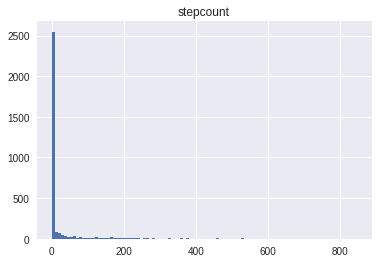

In [48]:
sc.hist(column='stepcount',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f481f2b5350>]],
      dtype=object)

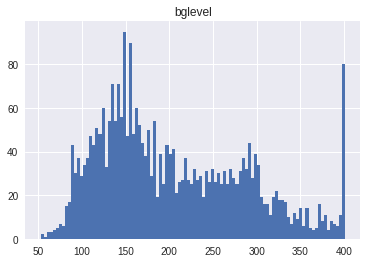

In [49]:
bg.hist(column='bglevel',bins=100)

### Data Preparation
#### Missing Value Treatment
Replace the missing values in bglevel column by corresponding time of the day's average bglevel for the given patient.

In [0]:
bg["time_of_day"] = bg.timestamp.apply(lambda x:x.time())

In [0]:
bg_time_of_day_avg = bg.groupby(["time_of_day"]).mean().reset_index()
bg_time_of_day_avg.columns = [u'time_of_day', u'avg_bglevel']

In [59]:
bg_new = pd.merge(bg, bg_time_of_day_avg, on='time_of_day')
bg_new.iloc[:5,:]

,timestamp,bglevel,time_of_day,avg_bglevel
0,2017-11-06 10:55:00,152.0,10:55:00,159.636364
1,2017-11-07 10:55:00,145.0,10:55:00,159.636364
2,2017-11-08 10:55:00,102.0,10:55:00,159.636364
3,2017-11-09 10:55:00,150.0,10:55:00,159.636364
4,2017-11-10 10:55:00,115.0,10:55:00,159.636364


In [0]:
bg_new.bglevel = bg_new.bglevel.fillna(value=bg_new.avg_bglevel)

In [62]:
bg_new.isnull().sum().sum()

0

#### Target Variable Definition
In this step, we need to define the target/dependent variable. As described in problem statement, target variable is " is decrease of bglevel more than 20 mg/dL between t and t+30mins".
For this we need to self join the bg data by the timestamp, keeping the 30 minutes difference in mind and also need to create a column called decrease_in_bg_level.
If decrease_in_bg_level>20 mg/dL , y =1
else y = 0.
 Once traget is defined, look at the frequencies of target variable to check if the event is rare or common. If it is rare, keep the fact in mind while doing model development or evaluation.

#### Feature Generation
Now create the required features such as time_of_day, bglevel_at_t, bglevel_before_t, stepcount_before_t etc.

#### Split Data
Create 2 sets of sample from data, one for training and one for testing/validation using the 70%(training), 30%(testing) split.

### Model Development
Since our task is classification task, we can use any decision tree based model to create the classifier.
Use the cross validation approach as well as ensemble based models such as Random Forest to avoid overfitting.
Once model is trained on training data, look at the accuracy/metric/performance of model on test data, if it is satisfactory, go ahead and deploy the model.